In [2]:
from sedfitter.sed import SEDCube
from sedfitter.fit import Fitter
from sedfitter.fit_info import FitInfoFile
from sedfitter.fit_info import FitInfo
from sedfitter.extinction import Extinction
from sedfitter.source import Source
import sedfitter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u
import os

In [3]:
models = os.listdir('../data/galaxySEDs/')
if '.DS_Store' in models: models.remove('.DS_Store')
models = [x for x in models if 'norm' not in x]
print((models))

['SF_Type2_AGN_1', 'WeakPAH_SF_glx_1', 'Ly_break', 'Type2_AGN_1', 'Torus', 'Young_SF_glx', 'MIR_powlaw_SF_glx', 'SF_Type1_AGN_1', 'SF_glx_2', 'Si_break', 'Red_SF_glx_2', 'Type1_AGN_1', 'Spiral', 'PAH_SF_glx', 'Mod_SF_glx', 'Blue_SF_glx', 'SF_Type2_AGN_2', 'Elliptical', 'SF_Type2_AGN_3', 'WeakPAH_SF_glx_2', 'Type2_AGN_2', 'Obs_SF_glx', 'MIRex_SF_glx', 'SF_glx_1', 'SF_Type1_AGN_2', 'Red_SF_glx_1', 'BroadFIR_SF_glx', 'SF_Type1_AGN_3', 'SF_Type1_AGN_4', 'Secular_glx', 'Warm_SF_glx', 'Cold_glx']


In [4]:
extinction = Extinction.from_file('../data/raw/whitney.r550.par')

In [5]:
apertures = [3., 3., 3., 3., 3., 3., 3., 3.] * u.arcsec

In [6]:
# Still want to replace this with Convolved filters
filters = ['2J', '2H', '2K', 'I1', 'I2', 'I3', 'I4', 'M1']
#filters = [1.235 * u.um, 1.662 * u.um, 2.159 * u.um, 3.6 * u.um, 4.5 * u.um, 5.8 * u.um, 8.0 * u.um, 23.675 * u.um]
filterpeaks = [1.235, 1.662, 2.159, 3.6, 4.5, 5.8, 8.0, 23.675]

In [ ]:
def fit(filts, aps, model, extinction, distance_r, av_r, remove_resolved, sourcefile):
    '''
    Function to fit a model directory to a source file
    Inputs:
        filters, apertures, path to model directory, extinction law, distance range, av range, remove_resolved, and an opened source file.
    Outputs: FitInfo Object
    '''
    fitter = Fitter(filts, aps, model,
              extinction_law=extinction,
              distance_range=distance_r,
              av_range=av_r, remove_resolved=remove_resolved)
    
    s = Source()
    try: s = Source.from_ascii(sourcefile.readline())
    except EOFError: break

    info = fitter.fit(s)
    return info

In [7]:
from astropy.visualization import quantity_support
quantity_support()

sourcepath = '../data/raw/SESNA_normalized'
sourcefile = open(sourcepath,'r')
savables = pd.DataFrame(columns = ['ID', 'Model', 'Model Fluxes', 'Source Flux', 'Source Error', 'Valid', 'Chi^2', 'Chi^2 DOF', 'Av', 'Scale'])

leash = 100

while True: # This while loop will run through each Source in SESNA, breaking the loop when it reaches the EOF
    try: s = Source.from_ascii(sourcefile.readline())
    except EOFError: break

    for galmod in models: # This for loop goes through each of the 32 galaxy models and fits them to the current SESNA source
        fitter = Fitter(filters, apertures, '../data/galaxySEDs/'+galmod,
                extinction_law=extinction,
                distance_range=[0.8, 2] * u.kpc,
                av_range=[0, 40.], remove_resolved=True)
        
        info = fitter.fit(s)

        # Data to be saved (modelfluxes, chi2, chi2 deg of freedom,)
        modelflux = info.model_fluxes[0]
        chi2 = info.chi2[0]
        chi2_DOF = len([x for x in s.valid if x == 1])
        sourcename = info.source.name
        source = np.array(info.source.to_ascii().split()[11:-1:2]).astype(float) # Make sure this is pulling the correct values. We take 11 to the last value because first 3 indices are ID and ra/dec, followed by 8 valid numbers
        sourceerror = np.array(info.source.to_ascii().split()[12::2]).astype(float) # This grabs error
        mask = np.array([True if x == 1 else False for x in info.source.valid])
        fitav = info.av[0]
        fitsc = info.sc[0]
        modelname = info.model_name[0]
        savables.loc[len(savables.index)] = [sourcename, modelname, modelflux, source, sourceerror, mask, chi2, chi2_DOF, fitav, fitsc]

    if leash == 0:
        break
    else: leash-=1

#output = '../data/outputs/output_ngc2264_Ly_break2.fitinfo'
#fout = FitInfoFile(output,'w')
#info = info.keep(output_format)
#fout.write(info)
#fout.close()

sourcefile.close()

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  SF_Type2_AGN_1
   Log[d] stepping     :  0.02

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

Data shape=(1, 8).  use_memmap=True
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/2J.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/2H.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/2K.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/I1.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/I2.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/I3.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/I4.fits
   Reading ../data/galaxySEDs/SF_Type2_AGN_1/convolved/M1.fits
 ------------------------------------------------------------
  => Model parameter

In [57]:
print(info.source.to_ascii().split()[11::2])

['7.576e-01', '1.000e+00', '1.084e+00', '5.046e-01', '3.582e-01', '2.500e-01', '4.543e-01', '4.075e+00']


In [21]:
print(info.source.valid)
mask = np.array([True if x == 1 else False for x in info.source.valid])
print(mask)
print(np.array(info.source.to_ascii().split()[11:-1:2]).astype(float)[mask])
print(np.array(info.source.to_ascii().split()[11:-1:2]).astype(float)[~mask])

[1 1 1 1 1 1 3 3]
[ True  True  True  True  True  True False False]
[0.7576 1.     1.084  0.5046 0.3582 0.25  ]
[0.4543 4.075 ]


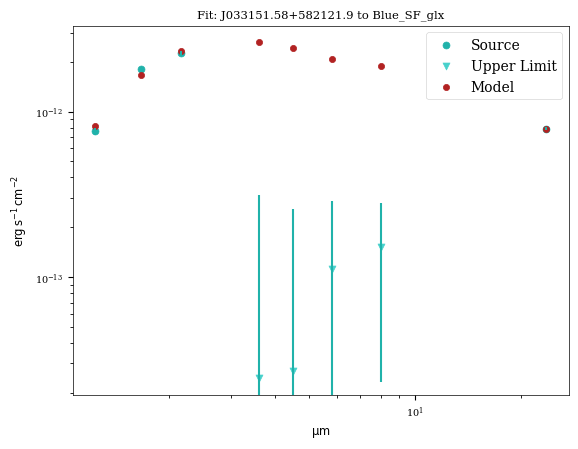

In [44]:
from astropy.visualization import quantity_support
quantity_support()

modelnum = 207

modellogfluxes = savables['Model Fluxes'][modelnum]
filterpeaks = [x for x in filterpeaks] * u.um
modelflux = 10**(modellogfluxes) * u.mJy
modelfluxdens = modelflux.to(u.erg / u.cm**2 / u.s, equivalencies = u.spectral_density(filterpeaks))
sourceflux =savables['Source Flux'][modelnum] 
sourceflux = sourceflux * u.mJy
sourcefluxdens = sourceflux.to(u.erg / u.cm**2 / u.s, equivalencies = u.spectral_density(filterpeaks))

sourceerror = savables['Source Error'][modelnum]
sourceerror = sourceerror * u.mJy
sourcerrordens = sourceerror.to(u.erg / u.cm**2 / u.s, equivalencies = u.spectral_density(filterpeaks))

mask = savables['Valid'][modelnum]

plt.scatter(filterpeaks[mask], sourcefluxdens[mask], c = 'lightseagreen',label = 'Source',s = 25) # Prints true values of the source
plt.scatter(filterpeaks[~mask], sourcefluxdens[~mask], c = 'mediumturquoise',label = 'Upper Limit', marker = 'v', s=25) # Prints upper limits of the source as triangles
plt.scatter(filterpeaks, modelfluxdens,color='firebrick', label = 'Model', s=20)
plt.errorbar(filterpeaks, sourcefluxdens, yerr=sourcerrordens,linestyle='', c='lightseagreen')
plt.xscale('log')
plt.yscale('log')
plt.title('Fit: ' + savables['ID'][modelnum]+ ' to ' + savables['Model'][modelnum])
plt.legend()



In [12]:
from astropy.io import fits 

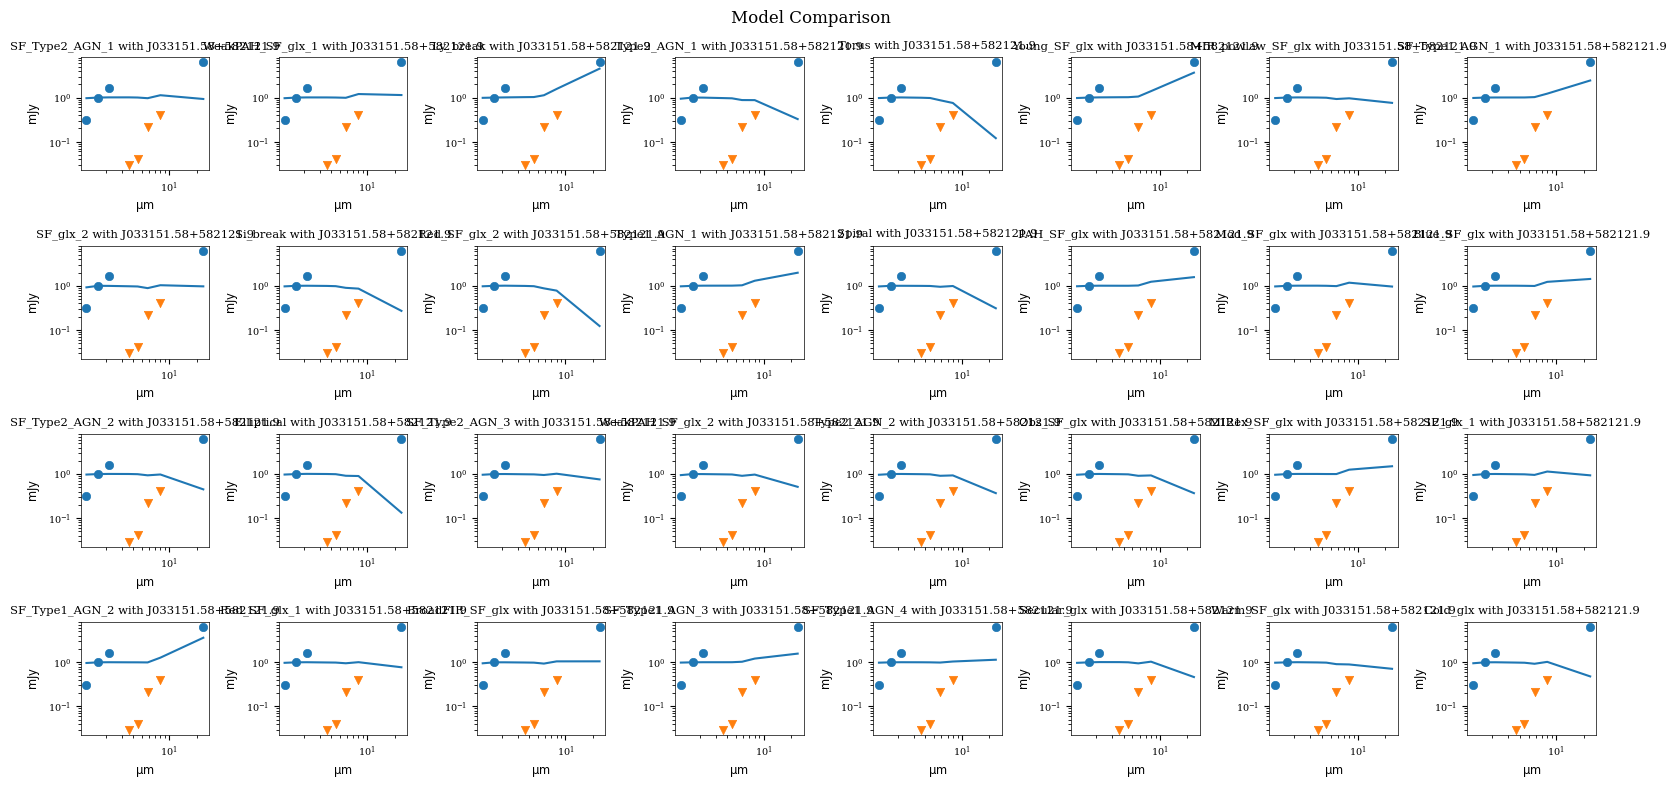

In [43]:
modelnum = 207

sourceflux = savables['Source Flux'][modelnum]
mask = savables['Valid'][modelnum]

    #convflux = retrieve_convolved_fluxes(model)
    #convflux = convflux / convflux[1] * u.mJy # normalize to H band
    #plt.figure()
    #plt.plot(filterpeaks,convflux)
    #plt.scatter(filterpeaks[mask],sourceflux[mask])
    #plt.scatter(filterpeaks[~mask],sourceflux[~mask],marker = 'v')
    #plt.title(model + ' with ' + savables['ID'][modelnum])
fig, axs = plt.subplots(4, 8, figsize=(16, 8))
fig.suptitle('Model Comparison')

for i, model in enumerate(models):
    convflux = retrieve_convolved_fluxes(model)
    convflux = convflux / convflux[1] * u.mJy # normalize to H band
    row = i // 8
    col = i % 8
    axs[row, col].plot(filterpeaks, convflux)
    axs[row, col].scatter(filterpeaks[mask], sourceflux[mask])
    axs[row, col].scatter(filterpeaks[~mask], sourceflux[~mask], marker='v')
    axs[row, col].set_title(model + ' with ' + savables['ID'][modelnum])
    axs[row, col].set_xscale('log')
    axs[row, col].set_yscale('log')

plt.tight_layout()
plt.show()


In [20]:
def retrieve_convolved_fluxes(model):
    convolvedflux = []
    for filt in filters:
        with fits.open('../data/galaxySEDS/'+model+'/convolved/'+filt+'.fits') as hdul:
            data = hdul[1].data
            convolvedflux.append(data[0][1][0])
    return np.array(convolvedflux)

In [42]:
savables[savables['Chi^2 DOF']>=4].sort_values(by='Chi^2')

,ID,Model,Model Fluxes,Source Flux,Source Error,Valid,Chi^2,Chi^2 DOF,Av,Scale
1921,J033155.48+582232.9,WeakPAH_SF_glx_1,"[-0.21834148784829832, -0.04186814503927738, 0...","[0.5982, 1.0, 1.104, 0.01155, 0.01603, 0.04797...","[0.01372, 0.03873, 0.03153, 0.1359, 0.1359, 0....","[True, True, True, False, False, False, False,...",9.256045016653125,4,3.116662593779644,0.045262797138905214
1948,J033155.48+582232.9,SF_Type1_AGN_4,"[-0.21739036788686805, -0.04414472894541538, 0...","[0.5982, 1.0, 1.104, 0.01155, 0.01603, 0.04797...","[0.01372, 0.03873, 0.03153, 0.1359, 0.1359, 0....","[True, True, True, False, False, False, False,...",9.651548174021878,4,3.173564183117046,-0.00017994235877787285
1946,J033155.48+582232.9,BroadFIR_SF_glx,"[-0.22247531425886968, -0.03282046939343064, 0...","[0.5982, 1.0, 1.104, 0.01155, 0.01603, 0.04797...","[0.01372, 0.03873, 0.03153, 0.1359, 0.1359, 0....","[True, True, True, False, False, False, False,...",10.167689511650902,4,3.2126687844403943,0.12144884877090219
207,J033151.58+582121.9,Blue_SF_glx,"[-0.4717749935001794, -0.03335480757670645, 0....","[0.3131, 1.0, 1.633, 0.02928, 0.04065, 0.216, ...","[0.01722, 0.0341, 0.03927, 0.3445, 0.3445, 0.3...","[True, True, True, False, False, False, False,...",11.190328564499529,4,8.113034658249301,-0.15387605514088917
214,J033151.58+582121.9,MIRex_SF_glx,"[-0.45955022873561946, -0.032938288568541696, ...","[0.3131, 1.0, 1.633, 0.02928, 0.04065, 0.216, ...","[0.01722, 0.0341, 0.03927, 0.3445, 0.3445, 0.3...","[True, True, True, False, False, False, False,...",12.122095989046429,4,7.888534178168615,-0.13412010388020654
...,...,...,...,...,...,...,...,...,...,...
1226,J032637.84+582215.7,Red_SF_glx_2,"[-0.3428104769817758, -0.332132759355681, -0.3...","[0.5581, 1.0, 0.7068, 0.3895, 0.3484, 0.4986, ...","[0.05807, 0.09348, 0.08924, 0.01416, 1.416, 1....","[True, True, True, True, False, False, False, ...",nan,4,0.0,0.219247104060241
1227,J032637.84+582215.7,Type1_AGN_1,"[-0.348275640377945, -0.3367179421281281, -0.3...","[0.5581, 1.0, 0.7068, 0.3895, 0.3484, 0.4986, ...","[0.05807, 0.09348, 0.08924, 0.01416, 1.416, 1....","[True, True, True, True, False, False, False, ...",nan,4,0.0,0.309048537795517
1228,J032637.84+582215.7,Spiral,"[-0.34655565201705196, -0.3325721639341662, -0...","[0.5581, 1.0, 0.7068, 0.3895, 0.3484, 0.4986, ...","[0.05807, 0.09348, 0.08924, 0.01416, 1.416, 1....","[True, True, True, True, False, False, False, ...",nan,4,0.0,0.4083190867278253
1218,J032637.84+582215.7,Ly_break,"[-0.3477648158635359, -0.34172126251117996, -0...","[0.5581, 1.0, 0.7068, 0.3895, 0.3484, 0.4986, ...","[0.05807, 0.09348, 0.08924, 0.01416, 1.416, 1....","[True, True, True, True, False, False, False, ...",nan,4,0.0,0.47645215490289833


In [32]:
savables[savables['ID'] == 'J032700.39+582301.8']

,ID,Model,Model Fluxes,Source Flux,Source Error,Valid,Chi^2,Chi^2 DOF,Av,Scale
3200,J032700.39+582301.8,SF_Type2_AGN_1,"[-0.31872983037585223, -0.3049635714208504, -0...","[0.7576, 1.0, 1.084, 0.5046, 0.3582, 0.25, 0.4...","[0.06098, 0.09909, 0.09451, 0.0122, 0.01372, 0...","[True, True, True, True, True, True, False, Fa...",nan,6,0.0,0.30034562080678445
3201,J032700.39+582301.8,WeakPAH_SF_glx_1,"[-0.31818625161963676, -0.30403989384490226, -...","[0.7576, 1.0, 1.084, 0.5046, 0.3582, 0.25, 0.4...","[0.06098, 0.09909, 0.09451, 0.0122, 0.01372, 0...","[True, True, True, True, True, True, False, Fa...",nan,6,0.0,0.3137047729388772
3202,J032700.39+582301.8,Ly_break,"[-0.3182660077894167, -0.31222245443706076, -0...","[0.7576, 1.0, 1.084, 0.5046, 0.3582, 0.25, 0.4...","[0.06098, 0.09909, 0.09451, 0.0122, 0.01372, 0...","[True, True, True, True, True, True, False, Fa...",nan,6,0.0,0.46170275086583873
3203,J032700.39+582301.8,Type2_AGN_1,"[-0.31456415191120324, -0.28915650978511986, -...","[0.7576, 1.0, 1.084, 0.5046, 0.3582, 0.25, 0.4...","[0.06098, 0.09909, 0.09451, 0.0122, 0.01372, 0...","[True, True, True, True, True, True, False, Fa...",235.69806029105328,6,0.0,0.2306289292118272
3204,J032700.39+582301.8,Torus,"[-0.3072878467888044, -0.2966910145283149, -0....","[0.7576, 1.0, 1.084, 0.5046, 0.3582, 0.25, 0.4...","[0.06098, 0.09909, 0.09451, 0.0122, 0.01372, 0...","[True, True, True, True, True, True, False, Fa...",235.21729660289995,6,0.0,0.13902058876307838
3205,J032700.39+582301.8,Young_SF_glx,"[-0.31956948870630886, -0.309390773715693, -0....","[0.7576, 1.0, 1.084, 0.5046, 0.3582, 0.25, 0.4...","[0.06098, 0.09909, 0.09451, 0.0122, 0.01372, 0...","[True, True, True, True, True, True, False, Fa...",nan,6,0.0,0.39301266786561323
3206,J032700.39+582301.8,MIR_powlaw_SF_glx,"[-0.31227361707417767, -0.3011389627906541, -0...","[0.7576, 1.0, 1.084, 0.5046, 0.3582, 0.25, 0.4...","[0.06098, 0.09909, 0.09451, 0.0122, 0.01372, 0...","[True, True, True, True, True, True, False, Fa...",nan,6,0.0,0.26880214884146353
3207,J032700.39+582301.8,SF_Type1_AGN_1,"[-0.3135255709957958, -0.30440752065895804, -0...","[0.7576, 1.0, 1.084, 0.5046, 0.3582, 0.25, 0.4...","[0.06098, 0.09909, 0.09451, 0.0122, 0.01372, 0...","[True, True, True, True, True, True, False, Fa...",nan,6,0.0,0.3168662555849493
3208,J032700.39+582301.8,SF_glx_2,"[-0.32477898077041867, -0.29027838186294797, -...","[0.7576, 1.0, 1.084, 0.5046, 0.3582, 0.25, 0.4...","[0.06098, 0.09909, 0.09451, 0.0122, 0.01372, 0...","[True, True, True, True, True, True, False, Fa...",nan,6,0.0,0.37127089836135985
3209,J032700.39+582301.8,Si_break,"[-0.3102334800775122, -0.2979160722012591, -0....","[0.7576, 1.0, 1.084, 0.5046, 0.3582, 0.25, 0.4...","[0.06098, 0.09909, 0.09451, 0.0122, 0.01372, 0...","[True, True, True, True, True, True, False, Fa...",240.22805410521417,6,0.0,0.1670008314607179


In [147]:
savables['Source Obj'][1218].error

array([0.06141825, 0.13220693, 0.09134468, 0.03682951, 0.49461758,
       0.70774547, 0.5951496 , 2.65605617])

In [144]:
# savables['Source Obj'][modelnum].flux
sourceflux = np.array(savables['Source Obj'][45].to_ascii().split()[11:-1:2]).astype(float)
sourceflux = sourceflux * u.mJy
sourcefluxdens = sourceflux.to(u.erg / u.cm**2 / u.s, equivalencies = u.spectral_density(filterpeaks))
print(sourcefluxdens[1])

1.803805403128761e-12 erg / (s cm2)


In [14]:
# Time to fit all of SESNA
3 * 5645590 / 60 / 60 / 24

196.02743055555558

In [15]:
6.5 / 10 * 5645590 / 60 / 60 / 24 # answer in days

42.4726099537037